In [1]:
import os
import pickle
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import json
import matplotlib as plt
import pandas as pd

In [2]:
def unpickle(file):
    """
    Load a CIFAR-10 batch file using pickle.

    Parameters:
        file (str): Path to the CIFAR-10 batch file.

    Returns:
        dict: Unpickled data from the file.
    """
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

train_data, train_labels = [], []

# load the training batches
for i in range(1, 6):
    batch = unpickle(f"data_batch_{i}")
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

# reshape and convert the training data and labels to numpy arrays
train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).astype(np.uint8)
train_labels = np.array(train_labels)

# load validation data
val_batch = unpickle("test_batch")
val_data = val_batch[b'data'].reshape(-1, 3, 32, 32).astype(np.uint8)
val_labels = np.array(val_batch[b'labels'])

print(f"Training Data Loaded: {train_data.shape}, Labels: {train_labels.shape}")
print(f"Validation Data Loaded: {val_data.shape}, Labels: {val_labels.shape}")

Training Data Loaded: (50000, 3, 32, 32), Labels: (50000,)
Validation Data Loaded: (10000, 3, 32, 32), Labels: (10000,)


In [3]:

# training transformations with data augmentation and random erasing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # randomly crop with padding
    transforms.RandomHorizontalFlip(),      # random horizontal flip
    transforms.RandomRotation(15),            # random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # slight color variation
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),
])

# validation transformations without augmentation
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

class CIFAR10Dataset(Dataset):
    """
    Custom Dataset for CIFAR-10 that applies transformations on the fly.
    """
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # convert image from (C, H, W) to (H, W, C) for PIL compatibility
        img = self.data[idx].transpose(1, 2, 0)
        label = self.labels[idx]
        img = Image.fromarray(img)  # convert to PIL Image
        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
# dataset objects for training and validation.
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform_train)
val_dataset = CIFAR10Dataset(val_data, val_labels, transform=transform_val)

# DataLoaders to handle batching and shuffling.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)

print(f"Train DataLoader Batches: {len(train_loader)}, Validation DataLoader Batches: {len(val_loader)}")

Train DataLoader Batches: 391, Validation DataLoader Batches: 100


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """
    A basic residual block for ResNet that implements the skip connection:
    F(x) + x, where F(x) consists of two Conv-BatchNorm layers.
    """
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        """
        Args:
            in_planes (int): Number of input channels.
            planes (int): Number of output channels.
            stride (int): Stride for the first convolution.
        """
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # need to configure shortcut connection if input and output dimensions differ
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        """
        Forward pass for the block.

        Args:
            x (Tensor): Input tensor

        Returns:
            Tensor: Output tensor after the residual connection
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    """
    ResNet architecture with dropout regularization.

    The network is constructed using the provided block type and a list defining
    the number of blocks per layer.
    """
    def __init__(self, block, num_blocks, num_classes=10):
        """
        Args:
            block (nn.Module): The residual block type.
            num_blocks (list): Number of blocks for each layer.
            num_classes (int): Number of classification classes
        """
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 96, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 256, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        """
        Create a sequential layer composed of residual blocks.

        Args:
            block (nn.Module): The block type to be used.
            planes (int): Number of output channels for the layer.
            num_blocks (int): Number of blocks in the layer.
            stride (int): Stride for the first block.

        Returns:
            nn.Sequential: A sequential container of residual blocks.
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass for ResNet.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Classification output.
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear(out)
        return out

def ResNet18():
    """
    Constructs a ResNet-18 model.

    Returns:
        ResNet: An instance of ResNet configured as ResNet-18.
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNet18().to(device)

# define loss function (with label smoothing) and SGD optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# configure OneCycleLR scheduler to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,                           # peak learning rate
    total_steps=200 * len(train_loader),  # total steps: epochs * batches per epoch
    pct_start=0.3,                        # percentage of steps to increase the learning rate
    div_factor=10.0,                      # initial LR = max_lr / div_factor
    final_div_factor=100.0,               # final LR = initial_lr / final_div_factor
    cycle_momentum=True,                  # enable momentum cycling
    base_momentum=0.85,                   # minimum momentum
    max_momentum=0.95                    # maximum momentum
)

print("Model, loss, optimizer, and scheduler initialized successfully!")


In [7]:
# check the params before training
print("\n🔍 Model Summary Before Training:")
summary(net, (3, 32, 32))


🔍 Model Summary Before Training:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 96, 32, 32]          27,648
       BatchNorm2d-4           [-1, 96, 32, 32]             192
            Conv2d-5           [-1, 96, 32, 32]          82,944
       BatchNorm2d-6           [-1, 96, 32, 32]             192
            Conv2d-7           [-1, 96, 32, 32]           3,072
       BatchNorm2d-8           [-1, 96, 32, 32]             192
        BasicBlock-9           [-1, 96, 32, 32]               0
           Conv2d-10           [-1, 96, 32, 32]          82,944
      BatchNorm2d-11           [-1, 96, 32, 32]             192
           Conv2d-12           [-1, 96, 32, 32]          82,944
      BatchNorm2d-13           [-1, 96, 32, 32]             192
     

In [ ]:
def train(net, train_loader, optimizer, device, epoch):
    """
    Train the model for one epoch using the OneCycleLR scheduler.

    Args:
        net (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        device (str): Device to run computations on ('cuda' or 'cpu').
        epoch (int): Current epoch number.

    Returns:
        tuple: Average training loss and training accuracy.
    """
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()  # update learning rate at each batch

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}")
    return avg_train_loss, train_acc

def validate(net, val_loader, device, epoch):
    """
    Evaluate the model on the validation set.

    Args:
        net (nn.Module): The model to evaluate.
        val_loader (DataLoader): DataLoader for validation data.
        device (str): Device to run computations on.
        epoch (int): Current epoch number.

    Returns:
        tuple: Average validation loss and validation accuracy.
    """
    net.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * correct / total
    print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")
    return avg_val_loss, val_acc

# lists to store metrics for analysis
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 200
best_val_acc = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}:")
    train_loss, train_acc = train(net, train_loader, optimizer, device, epoch)
    val_loss, val_acc = validate(net, val_loader, device, epoch)

    # save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(net.state_dict(), "best_model.pth")
        print(f"✅ Model saved at epoch {epoch+1} with Validation Accuracy: {val_acc:.2f}%")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# save training metrics to a JSON file for further analysis
metrics = {
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies
}

with open("training_metrics.json", "w") as f:
    json.dump(metrics, f)


Epoch 1:
Epoch 1: Train Loss: 1.8492 | Train Acc: 37.81% | LR: 0.010062
Validation Loss: 1.5114 | Validation Accuracy: 53.97%
✅ Model saved at epoch 1 with Validation Accuracy: 53.97%

Epoch 2:
Epoch 2: Train Loss: 1.5158 | Train Acc: 53.55% | LR: 0.010247
Validation Loss: 1.3487 | Validation Accuracy: 61.40%
✅ Model saved at epoch 2 with Validation Accuracy: 61.40%

Epoch 3:
Epoch 3: Train Loss: 1.3497 | Train Acc: 62.13% | LR: 0.010554
Validation Loss: 1.1988 | Validation Accuracy: 70.49%
✅ Model saved at epoch 3 with Validation Accuracy: 70.49%

Epoch 4:
Epoch 4: Train Loss: 1.2506 | Train Acc: 67.11% | LR: 0.010983
Validation Loss: 1.1596 | Validation Accuracy: 71.30%
✅ Model saved at epoch 4 with Validation Accuracy: 71.30%

Epoch 5:
Epoch 5: Train Loss: 1.1765 | Train Acc: 70.78% | LR: 0.011533
Validation Loss: 1.1202 | Validation Accuracy: 73.85%
✅ Model saved at epoch 5 with Validation Accuracy: 73.85%

Epoch 6:
Epoch 6: Train Loss: 1.1123 | Train Acc: 74.08% | LR: 0.012203
Va

In [ ]:
torch.save(net, 'resnet18_cycleLR_model.pth')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the trained model and set it to evaluation mode
model = torch.load("resnet18_cycleLR_model.pth", map_location=device)
model.to(device)
model.eval()
print("✅ Model loaded successfully!")

def load_cifar_batch(file):
    """
    Load a CIFAR batch from a pickle file.

    Args:
        file (str): Path to the pickle file.

    Returns:
        dict: Batch data containing images and IDs.
    """
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# load CIFAR test data (without labels)
file_path = "cifar_test_nolabel.pkl"
cifar10_batch = load_cifar_batch(file_path)

# extract test images and image IDs
test_images = cifar10_batch[b'data']  # expected shape: (N, 32, 32, 3)
image_ids = cifar10_batch[b'ids']
print(f"✅ Test set loaded: {test_images.shape}")

# convert test images to PyTorch tensors + rearrange dimensions + scale pixel values
test_images = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0

# define normalization transform (using training statistics)
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

# apply normalization to each image
test_images = torch.stack([normalize(img) for img in test_images])

# move test images to the designated device
test_images = test_images.to(device)
batch_size = 64  # inference batch size

predictions = []
with torch.no_grad():
    # run inference in batches
    for i in range(0, len(test_images), batch_size):
        batch = test_images[i:i+batch_size]
        outputs = model(batch)
        _, predicted_labels = torch.max(outputs, 1)
        predictions.extend(predicted_labels.cpu().numpy())

print("✅ Inference completed!")

# create a DataFrame for submission and save predictions to a CSV file
submission_df = pd.DataFrame({
    "ID": image_ids,
    "Labels": predictions
})
submission_filename = "cifar10_resnet_predictions.csv"
submission_df.to_csv(submission_filename, index=False)
print(f"✅ Predictions saved to {submission_filename}!")

In [ ]:
df = pd.read_csv("cifar10_resnet_predictions.csv")
label_counts = df["Labels"].value_counts()

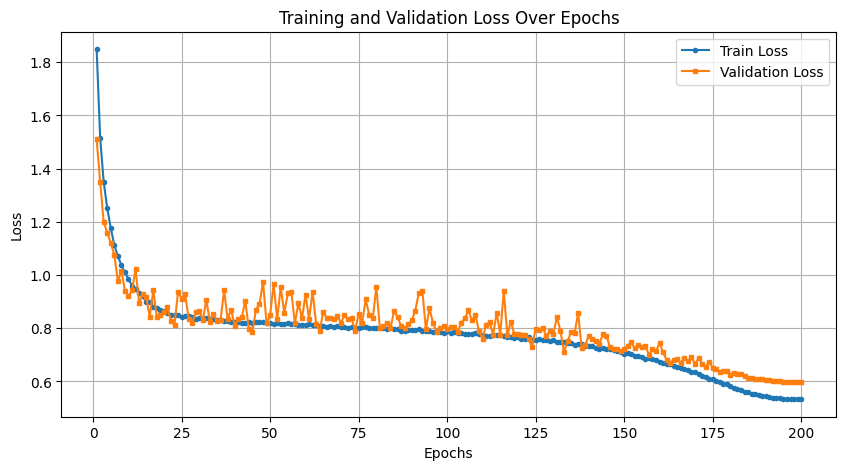

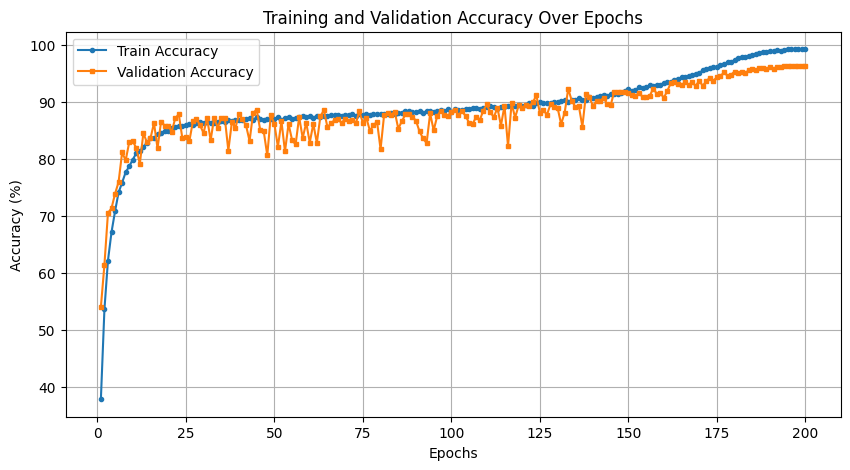

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 201)  # 200 epochs

# train loss vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss", linestyle='-', marker='o', markersize=3)
plt.plot(epochs, val_losses, label="Validation Loss", linestyle='-', marker='s', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# train accuracy vs validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label="Train Accuracy", linestyle='-', marker='o', markersize=3)
plt.plot(epochs, val_accuracies, label="Validation Accuracy", linestyle='-', marker='s', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()
